# Final Project: Supply requests analysis and forecast

## Mariia Torubara, 3/27/2020

#### Desription:
The following dataset was imported from the DB connected to JDE. ERP interface enables us not only to interact with the data, but also record all the changes to DB. There is a huge amount of stored tables. In my opinion, the most important are:

1. all supply (delivery) requests -> Sx documents
2. all purchase requests -> Ox documents
3. payments and obligations
4. users access properties
5. items settings 
6. storage location settings



So, in order to extract needed data from the respective table in DB, I used the following creteria:
1. Order type (all Sx documents)
2. Location (filtered with the help of cost center code -> all CC in the particular region starts the same. In my case: KYI..)
3. Time frame (all the docs that were created 01/01/2019 - 31/12/2019)


As I used to be an analyst in logistic, I decided to work exectly with Sx documents. Later on I will explain what these documets refer to. At the same time, I have to mention that ERP interface allows to clean the data before extraction, however raw data was taken to demonstrate gained skills.

#### Tasks:

1. Overall data description
2. Goods delivery analysis and efficiency
3. Costs allocaiton analytics upon items etimilogy analysis
4. Item(s) forecast


### Libraries import

In [36]:

import pandas as pd
import itertools
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.seasonal import seasonal_decompose
import matplotlib
import statsmodels.api as sm
from pandas.plotting import autocorrelation_plot
import statsmodels.formula.api as smf
from sklearn import model_selection, metrics
from statsmodels.tsa.api import VAR
%matplotlib inline
pd.options.mode.chained_assignment = None

from pylab import rcParams
rcParams['figure.figsize'] = 14, 6

import warnings
warnings.filterwarnings('ignore')

### Functions

In [5]:

#cleaning types
def definingTypes (yourDF):
    for i in range (len (yourDF.columns)):
        
        #if "Date" or "date" in yourDF.columns:
            #yourDF[i].columns.astype('datetime64')
            
        if "Quantity" or "quantity" in yourDF.columns[i]: #or "qty" or "Qty"
            yourDF[yourDF.columns[i]] = yourDF[yourDF.columns[i]].astype(float)
            yourDF[yourDF.columns[i]] = yourDF[yourDF.columns[i]].round (0)
            
        if "cost" or "Cost" or "Price" or "price" or "%" in yourDF.columns:
            yourDF[yourDF.columns[i]] = yourDF[yourDF.columns[i]].astype(float)
            yourDF[yourDF.columns[i]] = yourDF[yourDF.columns[i]].round (2)
            

#delete Nan rows
def deleteNaNrows (yourDF, rows): # if you put 999 - func will delete as all
    
    row0 = len (yourDF)
    
    if rows == 999:
        yourDF.dropna(axis=0, how="all",inplace=True)
    else:
        yourDF.dropna(axis=0, thresh = rows,inplace=True)
        
    row1 = len (yourDF)
    print ("Rows were deleted: ", row0-row1)

#delete Nan cols
def deleteNaNcols (yourDF, cols): # if you put 999 - func will delete as all
    
    col0 = len (yourDF.columns)
    if cols == 999:
        yourDF.dropna(axis=1,how = "all",inplace=True)
    else:
        yourDF.dropna(axis=1,thresh = cols,inplace=True)
    col1 = len (yourDF.columns)
    print ("Cols were deleted: ", col0-col1)
    
#deleting rows upon criteria
def delRow (yourDF, criteria):
    yourDF.drop(criteria)
    
#deleting cols upon criteria
def delCol (yourDF, criteriaList):
    yourDF.drop(criteriaList, axis = 1, inplace=True)
        

### File dowload and general overview

In [6]:
#downloading the file:

pd.set_option('display.max_columns', 130)
pd.set_option('display.max_rows', 250)
myOrders = pd.read_csv('mySR2019.csv')

myOrders = myOrders.rename(columns = {'Business Unit [F4211]':'Business unit','Or Ty [F4211]':'Order type'})
myOrders["Extended Price [F4211]"] = myOrders["Extended Price [F4211]"].astype(float)

deleteNaNrows (myOrders, 10)
deleteNaNcols (myOrders, 999)

myOrders = myOrders[myOrders["Cost Centre [F4211]"]!="non"] #deleting internal orders
myOrders.head()

Rows were deleted:  0
Cols were deleted:  7


,Order Co [F4211],Order Number [F4211],Order type,Line Number [F4211],Ord Suf [F4211],Business unit,Co [F4211],Doc Co [F4211],Original Order No [F4211],Orig Ord Type [F4211],Original Line Number [F4211],Co Key [F4211],Related PO/SO No [F4211],Rel Ord Type [F4211],Related PO/SO Line No [F4211],Agreement Number [F4211],Address Number [F4211],Ship To Number [F4211],Order Date [F4211],Sched Pick [F4211],Actual Ship Date [F4211],Invoice Date [F4211],Cancel Date [F4211],G/L Date [F4211],Promised Delivery [F4211],Price Effective Date [F4211],Reference [F4211],Short Item No [F4211],2nd Item Number [F4211],3rd Item Number [F4211],Frm Grd [F4211],Thr Grd [F4211],Description [F4211],Description Line 2 [F4211],Ln Ty [F4211],Next Stat [F4211],Last Stat [F4211],Header Business Unit [F4211],Group [F4211],Family [F4211],Max Lead time [F4211],Target [F4211],Import Licence [F4211],Item Option [F4211],Manufacturer [F4211],Purch Cat Code 3 [F4211],Plan Fmly [F4211],Cost Rule [F4211],UM [F4211],Quantity Ordered [F4211],Quantity Shipped [F4211],Quantity Backordered [F4211],Quantity Canceled [F4211],Qty Ship To Date [F4211],Comm [F4211],Unit Price [F4211],Extended Price [F4211],T P [F4211],Unit Cost [F4211],Doc Co [F4211].1,Document Number [F4211],Do Ty [F4211],Pick Number [F4211],Delivery Number [F4211],Priority (1/0) [F4211],PR UM [F4211],Cur Cod [F4211],Exchange Rate [F4211],Foreign Unit Price [F4211],Foreign Extended Price [F4211],Foreign Unit Cost [F4211],Reference 2 [F4211],Related Item No [F4211],AoE [F4211],Transaction Originator [F4211],F H [F4211],Zone Number [F4211],Carrier Number [F4211],Location [F4211],Lot Serial Number [F4211],Order Status 15 [F4211],W S [F4211],Parent Number [F4211],Request Date [F4211],Original Promised Date [F4211],Shipment Number [F4211],Exit Entry [F4211],Pay Terms Override [F4211],Buyer Number [F4211],Promotion ID [F4211],Secondary Qty Ordered [F4211],Sec UM [F4211],Order Status 16 [F4211],Deliver To Number [F4211],Revision Reason [F4211],Pending Approval [F4211],Chg Ord [F4211],Mod Trn [F4211],Pull Signal [F4211],Requested Del Time [F4211],Scheduled Pick Time [F4211],Original The [F4211],Actual Ship Time [F4211],Promised Del Time [F4211],Promised Ship [F4211],Ship To Line ID [F4211],Ship To Attention [F4211],Kit Identifier [F4211],In Fulfillment [F4211],Production Number [F4211],Cost Centre [F4211],Sub Type [F4211],Cross Dock Order Co [F4211],Cross Dock Order Number [F4211],Cross Dock Order Type [F4211],Cross Dock Line Number [F4211],Cross Dock Order Suffix [F4211],Primary Supplier [F4211]
0,1,19002548,CO,1.0,0,1DON400,1,1,19118792,SO,1.0,,,,NaN,,67967,71367,12/26/2019,12/26/2019,12/26/2019,12/27/2019,NaN,12/27/2019,12/26/2019,12/12/2019,,84100,KRELFOPA01P,KRELFOPA01P,1,ZZ,"FOOD PARCEL, individual/1 mont",h,WR,999,620,1DON400,K,REL,,,,,,,1H,,EA,-17.0,-10.0,NaN,NaN,-10,C,19.168,-191.68,,15.29,1.0,214092.0,RM,NaN,59229.0,0,EA,CHF,NaN,0,0,0,UKRNGENAECO0,,,A608490,,,NaN,WH_T3,2.02E+11,,,67967,12/26/2019,12/20/2019,NaN,,,61993.0,,-10.0,EA,,138763.0,,,0,,,0,0,0,0,0,12/26/2019,0,,1000,,,KYI2110,C,NaN,NaN,,NaN,,31042.0
1,1,19002548,CO,2.0,0,1DON400,1,1,19118792,SO,2.0,,,,NaN,,67967,71367,12/26/2019,12/26/2019,12/26/2019,12/27/2019,NaN,12/27/2019,12/26/2019,12/12/2019,,128917,KRELHYPA01P1,KRELHYPA01P1,1,ZZ,Hygienic Parcel for 1 person/1,month,WR,999,620,1DON400,K,REL,,,,,,,1H,,EA,-63.0,-10.0,NaN,NaN,-10,C,4.3847,-43.85,,2.58,1.0,214092.0,RM,NaN,59229.0,0,EA,CHF,NaN,0,0,0,UKRNGENAECO0,,,A608490,,,NaN,WH_T1,2.02E+11,,,67967,12/26/2019,12/20/2019,NaN,,,61993.0,,-10.0,EA,,138763.0,,,0,,,0,0,0,0,0,12/26/2019,0,,2000,,,KYI2110,C,NaN,NaN,,NaN,,31042.0
2,1,19002530,CO,1.0,0,1SEV400,1,1,19061470,SO,2.0,,,,NaN,,67979,71562,12/16/2019,12/16/2019,12/16/2019,12/17/2019,NaN,12/17/2019,12/16/2019,7/12/2019,,81862,HCOOCOUSGRAT,HCOOCOUSGRAT,1,ZZ,GRATER,,WR,999,620,1SEV400,H,COO,,,,,,,1H,,EA,-5.0,-3.0,NaN,NaN,-3,C,235,-705.00,,219.73,1.0,211682.0,RM,NaN,51146.0,0,EA,CHF,NaN,0,0,0,UKRNGENAECO0,,,A882002,,,NaN,WH1_GEN,2.02E+11,,,67979,12/1

Each item in the data set is an order's line.

There are several types of orders:
- SR - supply request
Upon SR is created:
- SP - petty cash supply
- SO - supply order (delivery from internal warehouse)
- SD - direct delivery from supplier
- SO/OP - urgent purchase order

SR is a request to purchase or deliver needed goods/services).

Each SR may contain several goods/services, for each good - separate line.

For easier terminology, I suggest to call each line just as Request.

So, each item of this data set (Request) consists of the following main features:


1. status (last and next) of the document: created, submitted for logistic review, submitted for approval, under approval, approved/declined, in work, released to the next doc and deleted.

2. type and number of the next document (direct deliver, supply from WH, purchase with following storage)

3. item codes + description + quantity

4. price + cost

5. sub-site ordering + subsite for whom the order is placed  + subsite which took care of the order + author + responsible logistician

6. decent amount of different dates (possiblity to evaluate logistics performance: approval time, working, delivery from the supplier, internal transfer, receiving etc)

7. cost centers and GO (we can trace the budget and purposes)


## 1.  Overall data description

In [7]:
#descriptive statemts:

mySRs = myOrders[(myOrders["Order type"]=="SR")]
mySXs = myOrders[(myOrders["Order type"]!="SR")&(myOrders["Order type"]!="ST")&
                 (myOrders["Order type"]!="CO")&(myOrders["Last Stat [F4211]"]!=980)&
                 (myOrders["2nd Item Number [F4211]"]!="PARCEL")]


#1 
SRsub = len(mySRs["Order Number [F4211]"]) #print ("Overall quantity of submitted SRs:", SRsub)

#2
SRproc = len(mySRs[mySRs["Last Stat [F4211]"]!=980]) #print ("Overall quantity of processed SRs:", SRproc)

#3
SRdeleted = len(mySRs[mySRs["Last Stat [F4211]"]==980]) #print ("Deleted SRs:", SRdeleted)

#4
SRwork = len(mySRs[mySRs["Next Stat [F4211]"]<625]) #print ("SRs in work:",SRwork)

#5
SRcomp = len(mySRs[(mySRs["Next Stat [F4211]"]==999) & (mySRs["Last Stat [F4211]"]!=980)]) #print ("SRs completed:",SRwork)


SRvalues = [SRsub, SRdeleted, SRproc, SRcomp,SRwork]
SRkeys = ["SUBMITTED:","(from them deleted)","RECIEVED:", "(from them completed)","(from them still in work)"]

d = {k:v for k,v in zip(SRkeys,SRvalues)}
SRdes_DF = pd.DataFrame(pd.Series(d), columns = ['Supply request, 2019'])
SRdes_DF.head(50)



,"Supply request, 2019"
SUBMITTED:,24685
(from them deleted),3018
RECIEVED:,21667
(from them completed),21662
(from them still in work),5


##### Conclusion:
There have been created almost 25 thousands requests. Out of them 3 thousands were deleted,  21667 lines were recieved by logistic department and were succesfully completed, except those 5 pcs.


In [8]:
#submitted SRs by sub-site (table):
mySRs = mySRs[mySRs["Quantity Ordered [F4211]"]!=0]
SStab = mySRs[["Order Number [F4211]","Business unit","Extended Price [F4211]"]]
SStab.round({"Unit Cost [F4211]":1})

SStabG1 = SStab.groupby("Business unit")["Order Number [F4211]"].agg(len)
SStabG2 = SStab.groupby("Business unit")["Extended Price [F4211]"].agg('sum')

SStabG = pd.merge (SStabG1, SStabG2, how = 'inner', on = 'Business unit')

SRss = pd.DataFrame(SStabG)
SRss = SRss.rename(columns={'Order Number [F4211]':'Requests quantity', "Extended Price [F4211]":"Requests cost (CHF)"})

cityList = ["(Donetsk)","(Kyiv)","(Luhansk)","(Mariupol)","(Severodonetsk)","(Slavyansk)"]
cityVal = SRss["Requests quantity"].tolist()
cityCost = SRss["Requests cost (CHF)"].tolist()
SRss["   "] = cityList

SRss.round({"Costs, CHF":1}) #Why it doesn't work?
SRss.index.names = [None]
SRss = SRss [["   ","Requests quantity", "Requests cost (CHF)"]]

SRss = SRss.sort_values ("Requests quantity", ascending = False)
SRss.round()


,,Requests quantity,Requests cost (CHF)
1KYI400,(Kyiv),10814,8888034.0
1DON400,(Donetsk),3438,9600044.0
1LUH400,(Luhansk),2272,4351373.0
1SEV400,(Severodonetsk),2147,1972263.0
1MRI400,(Mariupol),1855,1804553.0
1SLV400,(Slavyansk),1141,1341634.0


##### Conclusion:
The highest demand is presented in Kyiv, though the biggest expenses could be seen from Donetsk side.

##### Visulisation of the table above:

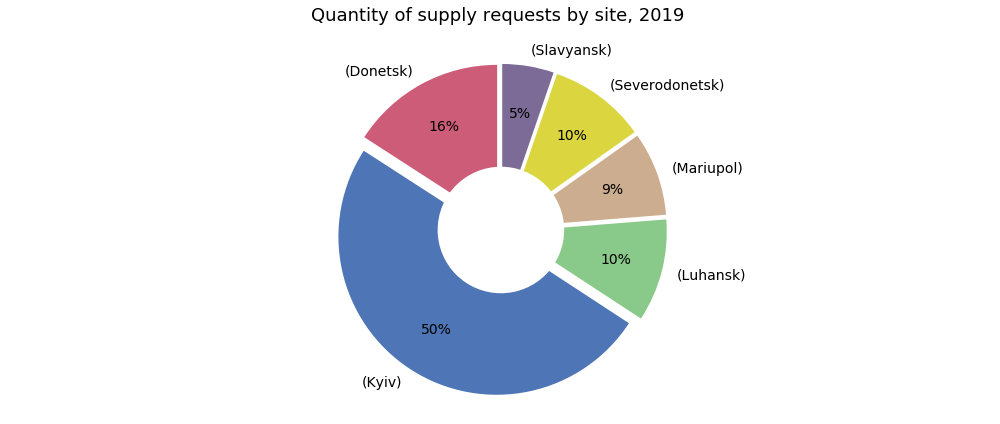

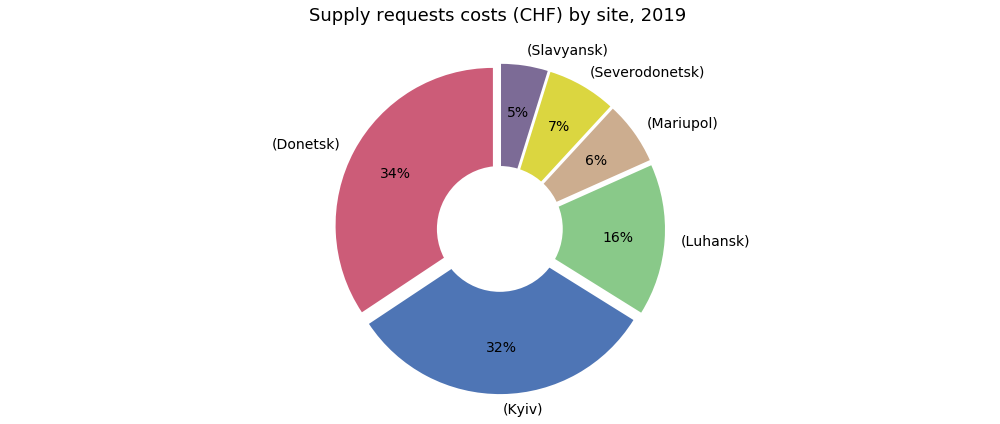

In [37]:
# Pie chart 1

labels = cityList
values = cityVal
costs = cityCost

#colors
colors = ['#cc5c78','#4e75b5','#89c989','#ccad8f','#dbd640', '#7c6b96']

#explsion
plt.figure(0)
explode = (0.05,0.05,0.05,0.05,0.05,0.05)
plt.pie(values, colors = colors, labels=labels, autopct='%1.f%%', 
        startangle=90, pctdistance=0.7, explode = explode, 
        textprops={'fontsize': 14})

#draw circle
centre_circle = plt.Circle((0,0),0.40,fc='white')
fig = plt.gcf()
fig.gca().add_artist(centre_circle)

# Equal aspect ratio ensures that pie is drawn as a circle
plt.axis('equal')
plt.title('Quantity of supply requests by site, 2019 \n', fontsize = 18 )
plt.tight_layout()
plt.show()

#----------

plt.figure(1)
explode = (0.05,0.05,0.05,0.05,0.05,0.05)
plt.pie(costs, colors = colors, labels=labels, autopct='%1.f%%', 
        startangle=90, pctdistance=0.7, explode = explode, 
        textprops={'fontsize': 14})

#draw circle
centre_circle = plt.Circle((0,0),0.40,fc='white')
fig = plt.gcf()
fig.gca().add_artist(centre_circle)

# Equal aspect ratio ensures that pie is drawn as a circle
plt.axis('equal')
plt.title('Supply requests costs (CHF) by site, 2019 \n', fontsize = 18)
plt.tight_layout()
plt.show()


##### Conclusion:
Even thoough Donetsk generated only 16% of all the orders, 1/3 of the total expenses belongs exactly to this location. From the other hand we can see that half of the generated orders came from Kyiv, however its expenses 2% lower than Donetsk's. From this charts we can make some conclusions regarding ratio of average orders costs among different locations.

## 2. Goods delivery analysis and efficiency

,Orders quantity,Orders cost (CHF),Average price per order (CHF)
Warehouse,18813,954908.0,51.0
Supplier deliveries,2981,2268765.0,761.0
Cash advance,2371,307199.0,130.0
Unplanned orders,153,786615.0,5141.0


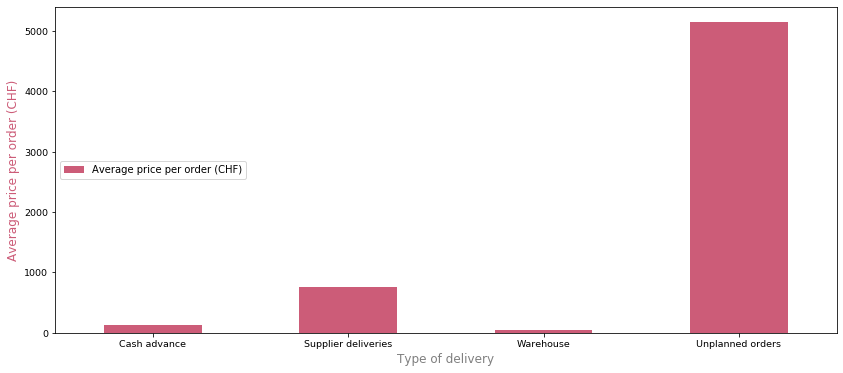

In [38]:
SPq = len(myOrders[(myOrders["Order type"]=="SP") & (myOrders["Last Stat [F4211]"]!=980)])
SDq = len (myOrders[(myOrders["Order type"]=="SD") & (myOrders["Last Stat [F4211]"]!=980)])
SOq = len (myOrders[(myOrders["Order type"]=="SO") & (myOrders["Last Stat [F4211]"]!=980)])
UnplOrdersq = len (myOrders[(myOrders["Rel Ord Type [F4211]"]=="OP") & (myOrders["Last Stat [F4211]"]!=980)])

SPc = myOrders[(myOrders["Order type"]=="SP") & (myOrders["Last Stat [F4211]"]!=980) & 
               (myOrders["Unit Cost [F4211]"]<2001)]["Unit Cost [F4211]"].agg('sum')
SDc = myOrders[(myOrders["Order type"]=="SD") & (myOrders["Last Stat [F4211]"]!=980)]["Unit Cost [F4211]"].agg('sum')
SOc = myOrders[(myOrders["Order type"]=="SO") & (myOrders["Last Stat [F4211]"]!=980)]["Unit Cost [F4211]"].agg('sum')
UnplOrdersc= myOrders[(myOrders["Rel Ord Type [F4211]"]=="OP") & (myOrders["Last Stat [F4211]"]!=980)]["Extended Price [F4211]"].agg('sum')

OrTyq = [SPq, SDq, SOq-UnplOrdersq, UnplOrdersq]
OrTyc = [SPc, SDc, SOc-UnplOrdersc, UnplOrdersc]
OrVal = ["Cash advance","Supplier deliveries","Warehouse","Unplanned orders"]

OrAn_DF = pd.DataFrame(pd.Series({k:v for k,v in zip(OrVal,OrTyq)}), columns = ["Orders quantity"])
OrAn_DF1 = pd.DataFrame(pd.Series({k:v for k,v in zip(OrVal,OrTyc)}), columns = ["Orders cost (CHF)"])
OrAn_DF ["Orders cost (CHF)"] = OrAn_DF1["Orders cost (CHF)"].tolist()
OrAn_DF.round(1)

OrAn_DF ["Average price per order (CHF)"] = OrAn_DF ["Orders cost (CHF)"] / OrAn_DF ["Orders quantity"]
OrAn_DF.round({'Average price per order (CHF)':1})

#OrAn_DF ["Average price per order (CHF)"].plot.bar()

figAv = OrAn_DF["Average price per order (CHF)"].plot.bar(color = ('#cc5c78'), fontsize = 9.5, rot = 0)
figAv.set_xlabel("Type of delivery", fontsize = 12, color = 'grey')
figAv.set_ylabel("Average price per order (CHF)", color = "#cc5c78", fontsize = 12)
figAv.legend(loc = 6)

OrAn_DF.sort_values("Orders quantity", ascending = False).round()

##### Conclusion:
Even though there were only 153 unplanned orderds in 2019, this category costs are almost twice higher than cash advance and supplier deliveries categories together. As we can see, average uplanned order is 50 times more expensive than cash advance order. However, procedure restricts uplanned orders with cost over 2000 CHF. 

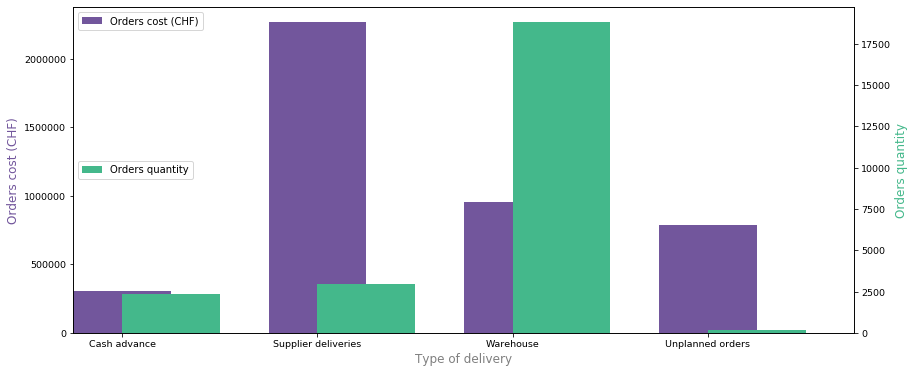

In [39]:
fig = OrAn_DF["Orders cost (CHF)"].plot.bar(color = "#72569c", fontsize = 9.5, rot = 0)
fig.set_xlabel("Type of delivery", fontsize = 12, color = 'grey')
fig.set_ylabel("Orders cost (CHF)", color = "#72569c", fontsize = 12)
fig.legend(loc = 2)


fig2 = fig.twinx()
fig2 = OrAn_DF["Orders quantity"].plot.bar(color = '#44b88b', fontsize = 9.5, position = 0)
fig2.set_ylabel("Orders quantity", fontsize = 12, color = "#44b88b")
fig2.legend(loc = 6)


##### Conclusion:
The most effective ($/qty) supplies are done from the warehouse. In all the rest cases costs surpass the outcome.

## 3. Costs allocaiton analytics upob items etimilogy analysis

All the items could be dived into logic groups, such as drugs, IT, veterinary items etc. Thanks to items classification, we can make some costs allocation analysis.

Principle: item code etimology

In [12]:
helpingTab = pd.read_csv('Items_and_deps.csv')
headerNames = helpingTab.iloc[0:0,:]
headerNames = list(headerNames)
items = mySXs[["2nd Item Number [F4211]",headerNames[0], headerNames[1] ]]
items.set_index ("2nd Item Number [F4211]", inplace = True)
items = items.drop_duplicates(keep='first')
items.head(10)

,Group [F4211],Family [F4211]
2nd Item Number [F4211],,
SCTRCLEAN01,S,CTR
SMAITRSP01,S,MAI
TMISMISC,T,MIS
STSPTRSP01,S,TSP
FMISMISC,F,MIS
RVOUFINAVALUE02,R,VOU
TVECFUELDIE1,T,VEC
SCOUCONUGEN,S,COU
AAUDLOUDLSM,A,AUD


In [13]:
# Preparing of table containing description of item codes etimology
helpingTab = pd.read_csv('Items_and_deps.csv')
headerNames = helpingTab.iloc[0:0,:]
headerNames = list(headerNames)
helpingTab ["Item Key"] = helpingTab [headerNames[0]] + helpingTab[headerNames[1]]
helpingTab 

# Preparing of our orders table
mySXs ["Item Key"] = mySXs [headerNames[0]] + mySXs[headerNames[1]]
mySXs

#Preparing of the table for analysis3
ItemsTab = pd.merge (helpingTab, mySXs, how = "inner", on = "Item Key")

DescGr = ItemsTab.groupby("Description")["Extended Price [F4211]"].agg(sum)
DescCSum = sum(ItemsTab.groupby("Description")["Extended Price [F4211]"].agg(sum))
DescGr = pd.DataFrame (DescGr)
DescGr ["Cost, %"] = ItemsTab.groupby("Description")["Extended Price [F4211]"].agg(sum)*100 / DescCSum
DescQSum = sum(ItemsTab.groupby("Description")["Extended Price [F4211]"].agg(len).tolist())
DescGr ["Orders, pcs"] = ItemsTab.groupby("Description")["Extended Price [F4211]"].agg(len)
DescGr ["Orders, %"] = ItemsTab.groupby("Description")["Extended Price [F4211]"].agg(len)*100 / DescQSum

DescGr = DescGr.rename(columns = {"Extended Price [F4211]":"Cost, CHF"})
DescGr.index.names = [None]

DescGr = DescGr.sort_values("Cost, CHF", ascending = False)
#lables = ['','','','','']
#explode0 = (0.05,0.05,0.05,0.05,0.05)
#Fig = DescGr.iloc[1:6,1:2].plot.pie(subplots=True, fontsize = 0, colors = colors, explode = explode0)
#plt.legend(loc = 0)

#centre_circle = plt.Circle((0,0),0.40,fc='white')
#fig = plt.gcf()
#fig.gca().add_artist(centre_circle)


DescGr.round()



,"Cost, CHF","Cost, %","Orders, pcs","Orders, %"
Services,34953453.0,62.0,2084.0,9.0
Food&Hygienic kits,4616865.0,8.0,1699.0,7.0
Engineering: utilities and houses,3256500.0,6.0,2813.0,12.0
Drugs,3218909.0,6.0,6319.0,26.0
"Housing, clothes, hyginiec",3184936.0,6.0,3219.0,13.0
Medical equipment,2484837.0,4.0,1517.0,6.0
Agro items,2183191.0,4.0,1245.0,5.0
Medical items,933790.0,2.0,2448.0,10.0
IT,848969.0,2.0,575.0,2.0
Dead bodies management,304516.0,1.0,449.0,2.0


##### Conclusion:
As we can see, the most cosuming part is services - it takes 61% of the used budget or 34 mCHF, but only 9% of total orders quantity. It enbles us to make assumptions about reltive services high cost. Next comes food and hygienic kits which take almost 9% of the whole budget and 7% of total orders quantity. From the other hand, medical items category, whith its relatively low costs (1.6% of the overall expenses), is presented in each 10th order.

In the same time, we can easily make sosts allocations by department. We can use either etimology of the item code (as I did with groups), or cost centers (more accurate). In this case i used the same approach as before.

,"Cost, CHF","Cost, %","Orders, pcs","Orders, %"
EcoSec,10145452.0,48.0,6395.0,31.0
Medical dep,6653792.0,31.0,10347.0,49.0
WatHab,3256500.0,15.0,2813.0,13.0
IT,848969.0,4.0,575.0,3.0
Forensic,304516.0,1.0,449.0,2.0
Other,92498.0,0.0,217.0,1.0
Communication,29652.0,0.0,123.0,1.0


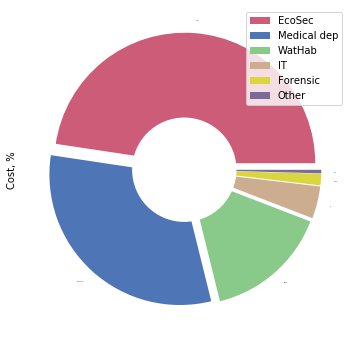

In [40]:
#Let's take a look at departments shares

ItemsTab = ItemsTab[ItemsTab["Department"]!="Admin"] #excluding admin - not interesting
DescDep = ItemsTab.groupby("Department")["Extended Price [F4211]"].agg(sum)
DescCSum = sum(ItemsTab.groupby("Department")["Extended Price [F4211]"].agg(sum))
DescDep = pd.DataFrame (DescDep)
DescDep ["Cost, %"] = ItemsTab.groupby("Department")["Extended Price [F4211]"].agg(sum)*100 / DescCSum
DescQSum = sum(ItemsTab.groupby("Department")["Extended Price [F4211]"].agg(len).tolist())
DescDep ["Orders, pcs"] = ItemsTab.groupby("Department")["Extended Price [F4211]"].agg(len)
DescDep ["Orders, %"] = ItemsTab.groupby("Department")["Unit Cost [F4211]"].agg(len)*100 / DescQSum

DescDep = DescDep.rename(columns = {"Extended Price [F4211]":"Cost, CHF"})
DescDep.index.names = [None]

explode0 = (0.05,0.05,0.05,0.05,0.05,0.05)
DescDep = DescDep.sort_values("Cost, CHF", ascending = False)
Fig = DescDep.iloc[0:6,1:2].plot.pie(subplots=True, fontsize = 0, colors = colors, explode = explode0)

centre_circle = plt.Circle((0,0),0.40,fc='white')
fig = plt.gcf()
fig.gca().add_artist(centre_circle)

DescDep.round()



##### Conclusion:
Half of the spent budget and 1/3 of all the orders belong to EcoSec department. In the same time medical departmnts has situation vice cersa: 1/3 of the budget and half of the orders.

## 4. Item(s) forecast

There are several hunders unique items in our dataset. In order to decide wich item(s) is (are) going to be the base for my model, I decided to use several approaches. Here are they:

### Approach no. 1: Top items selection 
##### Groups: departments. Categories: quantity and cost

In [15]:
#Creation of 

Desc = ItemsTab[ItemsTab ["Description"]!="Services"]  
biggestDeps = ["Medical dep", "WatHab", "EcoSec"] #here we choose which departments' items we'd like to analyze

TopItemsQ = []
for i in biggestDeps:
    TopItems = Desc[Desc["Department"] == i]
    TopItems = TopItems.groupby("2nd Item Number [F4211]")["Quantity Ordered [F4211]"].agg(len)
    TopItems = pd.DataFrame(TopItems)
    TopItems["Department"] = i
    TopItems ["Description"] = Desc["Description  [F4211]"]
    TopItems = TopItems.sort_values("Quantity Ordered [F4211]", ascending = False)
    TopItemsQ.append(TopItems.iloc[0:1,0:2])
    
TopItemsC = []
for i in biggestDeps:
    TopItems = Desc[Desc["Department"] == i]
    TopItems = TopItems.groupby("2nd Item Number [F4211]")["Extended Price [F4211]"].agg(sum)
    TopItems = pd.DataFrame(TopItems)
    TopItems["Department"] = i
    TopItems = TopItems.sort_values("Extended Price [F4211]", ascending = False)
    TopItemsC.append(TopItems.iloc[0:4,0:2])
    
resTabCost = pd.DataFrame ()
resTabQty = pd.DataFrame ()

for i in range (len(biggestDeps)):
    resTabCost = resTabCost.append(TopItemsC[i])
    resTabQty = resTabQty.append(TopItemsQ[i])

    
resTabQty.rename(columns = {"Quantity Ordered [F4211]":"Orders, 2019"})

,"Orders, 2019",Department
2nd Item Number [F4211],,
DORAAMLOZ00001,280.0,Medical dep
EBUIBSHEZ00012,145.0,WatHab
KRELFOPA01P,750.0,EcoSec


##### Comment: 

Top 3 most frequently ordered items.


In [16]:
resTabCost.rename(columns = {"Extended Price [F4211]":"Costs, 2019"}).head(20)

,"Costs, 2019",Department
2nd Item Number [F4211],,
DORAMDRT09,425934.89,Medical dep
DORAARVSZ00004,376892.90,Medical dep
DORAMDRT03,312383.62,Medical dep
DINJMDRT03,280785.60,Medical dep
WASDVASDZ00006,428719.71,WatHab
EBUIBSHEZ00012,219269.50,WatHab
WNEPPE1WZ00001,172592.88,WatHab
WNEPPE1WZ00002,99131.68,WatHab
KRELFOPA01P,3694986.08,EcoSec


##### Comment: 

Top 12 items that have the highest overall cost. Some of the items were uniquly ordered several times, but due to high price appeared in this top. Such items either are not interesdted to be forecasted or just couldn't be forecasted. 

It means we have to pick 3 items for top manually upon logic:


In [17]:
resTabCost = resTabCost.loc[["RAGRTOOLZ00052","EBUIBSHEZ00012","KRELFOPA01P"],:] #RAGRTOOLZ00052
resTabCost

,Extended Price [F4211],Department
2nd Item Number [F4211],,
RAGRTOOLZ00052,1131518.97,EcoSec
EBUIBSHEZ00012,219269.50,WatHab
KRELFOPA01P,3694986.08,EcoSec


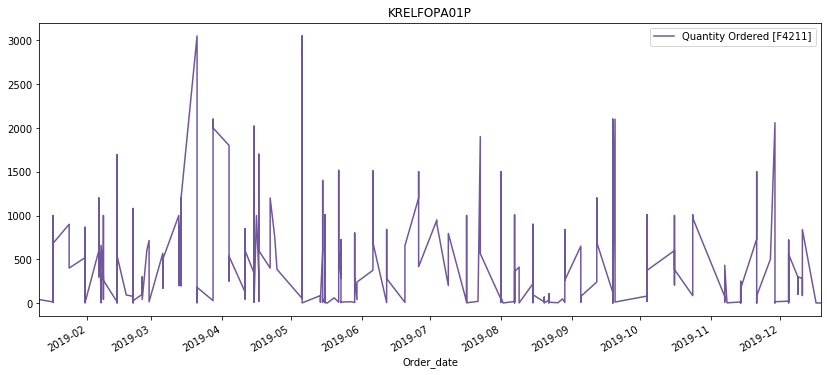

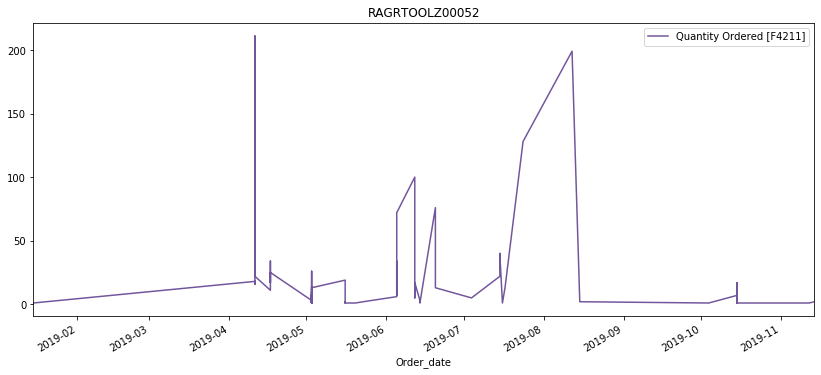

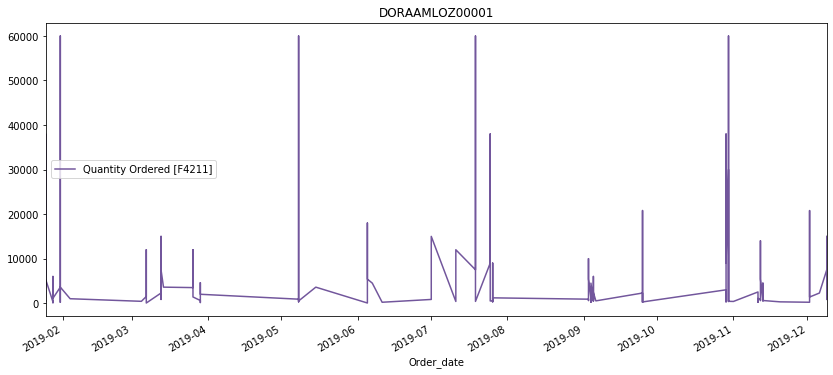

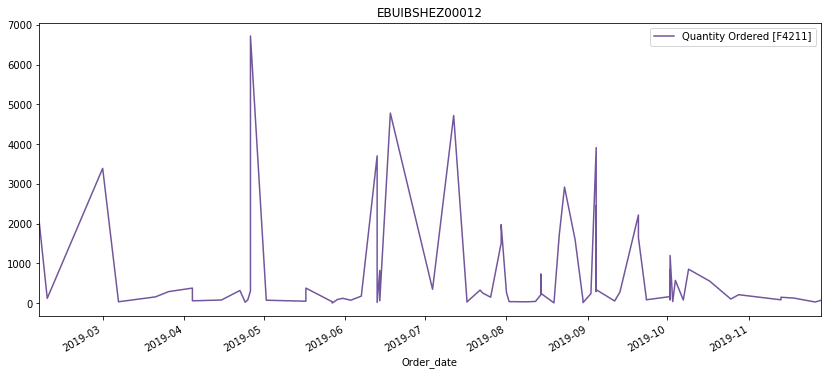

In [41]:
buf0 = resTabQty.iloc[:,0:0]
buf1 = resTabCost.iloc[:,0:0]
buf = buf0 & buf1
mySRs = mySRs[mySRs["Quantity Ordered [F4211]"]!=0]
mySRsF = pd.merge (buf, mySRs, how = "left", on = "2nd Item Number [F4211]")

mySRsF = mySRsF [["Order Date [F4211]","Order type", "Order Number [F4211]","Business unit", "2nd Item Number [F4211]",
                  'Description  [F4211]', 'Extended Price [F4211]', 'Quantity Ordered [F4211]']]

mySRsF.rename(columns = {'Order Date [F4211]':'Order_date'}, inplace = True)
mySRsF = mySRsF.set_index("Order_date")
mySRsF.index = pd.to_datetime(mySRsF.index)
mySRsF = mySRsF.sort_values("Order_date", ascending = True)

#Let's have a look on our choice
codesSR = mySRsF["2nd Item Number [F4211]"].unique()
mySRsPlot = mySRsF[["Quantity Ordered [F4211]","2nd Item Number [F4211]"]]

plotArray = []
titleArray = []

for i in codesSR:
    mySRsPlot[mySRsPlot["2nd Item Number [F4211]"]==i].plot(title = i, color = '#72569c')
    plotArray.append(mySRsPlot[mySRsPlot["2nd Item Number [F4211]"]==i])
    titleArray.append(i)

According to the chart, reality is confirmed: there is an obvious connection between KRELHYPA01P1 (hygienic parcel) and KRELFOPA01P (food parcel).

More interseting for us would be correlation between time stamps and ordered quantity:

In [19]:
print (titleArray)
ind = [x for x in range (0,len (titleArray))]
dict1 = {k:v for k,v in zip (ind, titleArray)}
dict1

['KRELFOPA01P', 'RAGRTOOLZ00052', 'DORAAMLOZ00001', 'EBUIBSHEZ00012']


{0: 'KRELFOPA01P',
 1: 'RAGRTOOLZ00052',
 2: 'DORAAMLOZ00001',
 3: 'EBUIBSHEZ00012'}

You can choose which item to forecast: 

In [20]:
choice = 0

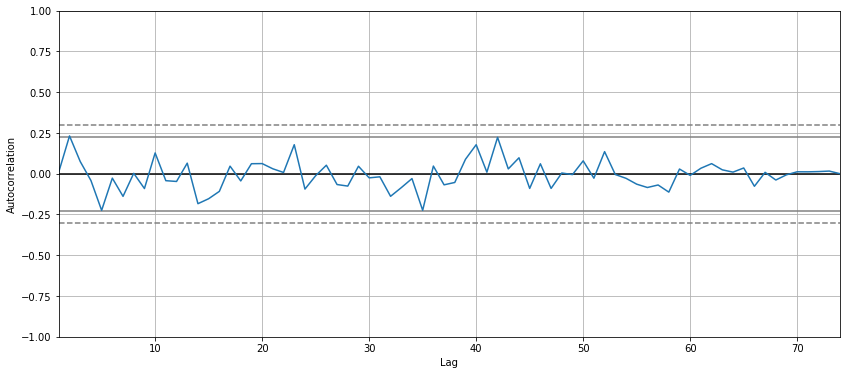

In [42]:
corrMod = plotArray[choice][["2nd Item Number [F4211]", "Quantity Ordered [F4211]"]]
corrMod = corrMod[corrMod["Quantity Ordered [F4211]"]!=0]
corrMod = corrMod.groupby("Order_date")["Quantity Ordered [F4211]"].sum().reset_index()
corrMod = corrMod.set_index("Order_date")
corrMod.index = pd.to_datetime(corrMod.index)
corrMod.rename(columns = {'Quantity Ordered [F4211]':'Quantity_ordered'}, inplace = True)
autocorrelation_plot (corrMod)

##### Conclusion:
There is no reliable correlation between time stamps and ordered quantity for any of the items.

To make reliable forecast model, I have to find correlations amongs items.

### Approach no. 2: Correlation researches

In [22]:
uniqueItems = mySRs["2nd Item Number [F4211]"].unique()
mySRs = mySRs[mySRs["Quantity Ordered [F4211]"]!=0]
corrFrame = []
corrArray = []



for i in uniqueItems:
    corrFrame.append(mySRs[mySRs["2nd Item Number [F4211]"]==i])
    
for i in range (len (corrFrame)):
    corrFrame[i] = corrFrame[i] [["Order Date [F4211]","Quantity Ordered [F4211]"]]
    corrFrame[i].set_index("Order Date [F4211]", inplace = True)
    corrFrame[i].index = pd.to_datetime(corrFrame[i].index)
    corrFrame[i].groupby ("Order Date [F4211]").agg(sum)
    corrFrame[i].rename(columns = {"Quantity Ordered [F4211]":uniqueItems[i]}, inplace = True)
    corrArray.append(corrFrame[i][uniqueItems[i]].resample('M').mean())

 
for i in range (len (corrArray)):
    pd.DataFrame (corrArray[i])

itemsCorrMod = pd.DataFrame()
itemsCorrMod = corrArray [0]
    
for i in range (1, len (corrArray)):
    itemsCorrMod = pd.merge (itemsCorrMod, corrArray [i],on = "Order Date [F4211]", how = "outer")
    
for i in range (2,12):
    itemsCorrMod.dropna(axis=1, thresh = i, inplace=True)

corr = pd.DataFrame()
corr = itemsCorrMod.corr()
corr = corr[corr.iloc[:,:]>0.5]


Below, here is a matrix of items that have correlation with other item(s) over 0.5 -> reliable connetion.


In [23]:
corr

,AFODMWATZ00003,APACBAGP100,APERBPACZ00002,ASTANOBOA5,ASTANOBOZ00014,ASTAPENSBBLU,DASDETHAG475,DASDIODP1S1,DINJCEFT1V,DORAENALZ00003,EBUIWOODZ00038,EBUIWOODZ00039,EBUIWOODZ00040,EBUIWOODZ00041,EHDWNAILX100,FMISMISC,HCLSGLOVZ00001,HCOOCUGLZ00012,HHYGSOAPB010,HHYGSOAPBOX1,HMISMISC,HSHETARPW406,KMEDSDRE01,KRELFOPA01P,KRELHYPA01P1,MDREBANDE08,MDREBANDG08,MDREBTRI136,MDRECOMPG10N,MDRETADSP02,MDRETADSP05,MFOEBAGP42,MINSCNTR5C,MINSNEEDHS21,MLASLANC1D,MMREGLOVEM,RAGRSEEDZ00009,RFERNPKFKG,SADMDAIL01,SADMFINA01,SADMMIED01,SCOUCONUGEN,SCTRBUIWD01,SCTRCIVWD01,SMAITRSP01,STSPPAHAH01,STSPTRSP01,STSPTRSPM01,TMISMISC,TVECFUELPET1,XLABGLMTZ00008,XSINMEDI030614
AFODMWATZ00003,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
APACBAGP100,NaN,1.000000,NaN,NaN,0.635514,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.679912,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.780875,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
APERBPACZ00002,NaN,NaN,1.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.915775,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.964949,NaN,NaN,0.828498,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
ASTANOBOA5,NaN,NaN,NaN,1.000000,NaN,NaN,NaN,NaN,NaN,0.556873,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.591721,0.591721,NaN,NaN,NaN,NaN,NaN,0.591721,NaN,NaN,0.591721,NaN,NaN,NaN,NaN,0.690912,0.745860,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.738765,NaN,NaN,NaN,NaN,0.736996,NaN,NaN,0.591721
ASTANOBOZ00014,NaN,0.635514,NaN,NaN,1.000000,NaN,NaN,0.801205,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.591588,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.801261,0.728703,NaN,NaN,0.785493,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
ASTAPENSBBLU,NaN,NaN,NaN,NaN,NaN,1.000000,NaN,NaN,NaN,NaN,0.633607,NaN,NaN,NaN,NaN,NaN,0.776438,NaN,0.708976,0.708976,NaN,NaN,NaN,NaN,NaN,0.708976,NaN,NaN,0.708976,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.979807,NaN,0.708976
DASDETHAG475,NaN,NaN,NaN,NaN,NaN,NaN,1.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.615156,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.936324,NaN,0.673723,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
DASDIODP1S1,NaN,NaN,NaN,NaN,0.801205,NaN,NaN,1.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.996711,0.984667,NaN,NaN,0.927881,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
DINJCEFT1V,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.639051,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.717654,NaN,0.573123,NaN,NaN,NaN,0.501333,NaN,NaN,NaN,NaN
DORAENALZ00003,NaN,NaN,NaN,0.556873,NaN,NaN,NaN,NaN,NaN,1.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.514567,0.737171,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.589398,NaN,NaN,NaN,NaN,0.620469,NaN,NaN,NaN


##### Comment:

Here we can see items with sum of correlation over 5  ->  it's items that have reliable connection with 4+ other items except themselves.


In [24]:
corrSum = corr.sum(numeric_only=True, axis=0)
corrSum = pd.DataFrame(corrSum, columns = {"Correlation sum"})
corrSum = corrSum[corrSum["Correlation sum"]>5].sort_values("Correlation sum", ascending = False)
corrSum.rename(index = {"":"2nd Item Number [F4211]"})
corrSum

,Correlation sum
MDREBANDE08,9.810283
HHYGSOAPB010,9.810283
HHYGSOAPBOX1,9.810283
XSINMEDI030614,9.810283
MDRECOMPG10N,9.810283
MFOEBAGP42,9.503144
EBUIWOODZ00038,8.907240
ASTANOBOA5,7.428013
TVECFUELPET1,7.307210
MLASLANC1D,7.019744


Among all the items, the most inetrestig for me appers to be TVECFUELPET1:

In [25]:
mySRs[mySRs["2nd Item Number [F4211]"] == "TVECFUELPET1"][["2nd Item Number [F4211]","Description  [F4211]"]].iloc[0:1,:]

,2nd Item Number [F4211],Description [F4211]
51766,TVECFUELPET1,"PETROL FUEL, per liter"


So, let's have a look at the list of "connected" to petrol items:

In [26]:
corrPetrol = corr.loc [:,"TVECFUELPET1"]
corrPetrol = pd.DataFrame(corrPetrol)
corrPetrol.dropna(axis = 0, inplace = True)
corrPetrol.index.name = "Item code"
corrPetrol

,TVECFUELPET1
Item code,
ASTAPENSBBLU,0.979807
EBUIWOODZ00038,0.693486
EBUIWOODZ00041,0.581358
HHYGSOAPB010,0.697022
HHYGSOAPBOX1,0.697022
MDREBANDE08,0.697022
MDRECOMPG10N,0.697022
MFOEBAGP42,0.567452
TVECFUELPET1,1.000000


I found connection between petrol and wood to be interesting. In the same time, all the rest (like correlation with blue pens) is a pure coincidence.

In [27]:
petrolItems = ["TVECFUELPET1", "EBUIWOODZ00038", "EBUIWOODZ00039", "EBUIWOODZ00041"]
descPetrol = pd.DataFrame ()
petrol = mySRs[mySRs["2nd Item Number [F4211]"] == "TVECFUELPET1"][["2nd Item Number [F4211]","Description  [F4211]"]].iloc[0:1,:]
iteml = mySRs[mySRs["2nd Item Number [F4211]"] == "EBUIWOODZ00038"][["2nd Item Number [F4211]","Description  [F4211]"]].iloc[0:1,:]
item2 = mySRs[mySRs["2nd Item Number [F4211]"] == "EBUIWOODZ00039"][["2nd Item Number [F4211]","Description  [F4211]"]].iloc[0:1,:]
item3= mySRs[mySRs["2nd Item Number [F4211]"] == "EBUIWOODZ00041"][["2nd Item Number [F4211]","Description  [F4211]"]].iloc[0:1,:]

descPetrol = petrol
descPetrol = descPetrol.append(iteml).append(item2).append(item3)
descPetrol

,2nd Item Number [F4211],Description [F4211]
51766,TVECFUELPET1,"PETROL FUEL, per liter"
38966,EBUIWOODZ00038,"OSB, 2500mm x 1250mm x 10mm, e"
39033,EBUIWOODZ00039,"TIMBER, 100 x 100 x 4000 mm,"
39138,EBUIWOODZ00041,"TIMBER, 25 x 100 x 4000 mm,"


Here we have a chart of wood and petrol orders quantity changing over the time.

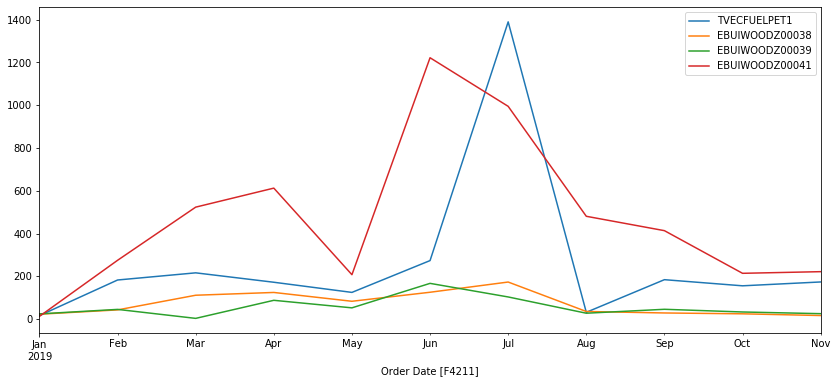

In [43]:

corrFrameP = []
corrArrayP = []

for i in petrolItems:
    corrFrameP.append(mySRs[mySRs["2nd Item Number [F4211]"]==i])

for i in range (len (corrFrameP)):
    corrFrameP[i] = corrFrameP[i] [["Order Date [F4211]","Quantity Ordered [F4211]"]]
    corrFrameP[i].set_index("Order Date [F4211]", inplace = True)
    corrFrameP[i].index = pd.to_datetime(corrFrameP[i].index)
    corrFrameP[i].groupby ("Order Date [F4211]").agg(sum)
    corrFrameP[i].rename(columns = {"Quantity Ordered [F4211]":petrolItems[i]}, inplace = True)
    corrArrayP.append(corrFrameP[i][petrolItems[i]].resample('M').mean())

for i in range (len (corrArrayP)):
    pd.DataFrame (corrArrayP[i])

itemsCorrModP = pd.DataFrame()
itemsCorrModP = corrArrayP [0]
    
for i in range (1, len (corrArrayP)):
    itemsCorrModP = pd.merge (itemsCorrModP, corrArrayP[i],on = "Order Date [F4211]", how = "outer")
    
for i in range (2,12):
    itemsCorrModP.dropna(axis=1, thresh = i, inplace=True)

itemsCorrModP = itemsCorrModP.iloc[0:11,:]
itemsCorrModP.plot()  

In [29]:
itemsCorrModP.corr()

,TVECFUELPET1,EBUIWOODZ00038,EBUIWOODZ00039,EBUIWOODZ00041
TVECFUELPET1,1.000000,0.693486,0.427392,0.581358
EBUIWOODZ00038,0.693486,1.000000,0.648259,0.795878
EBUIWOODZ00039,0.427392,0.648259,1.000000,0.834656
EBUIWOODZ00041,0.581358,0.795878,0.834656,1.000000


Here is our model and it's statistic:

In [30]:
petrol_reg = smf.ols("TVECFUELPET1 ~ np.power(EBUIWOODZ00039,3) + np.power(EBUIWOODZ00038,5) + np.power(EBUIWOODZ00041,4)",
                      data=itemsCorrModP).fit()
petrol_reg.summary()


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:           TVECFUELPET1   R-squared:                       0.969
Model:                            OLS   Adj. R-squared:                  0.955
Method:                 Least Squares   F-statistic:                     72.49
Date:                Fri, 27 Mar 2020   Prob (F-statistic):           1.23e-05
Time:                        04:04:16   Log-Likelihood:                -61.364
No. Observations:                  11   AIC:                             130.7
Df Residuals:                       7   BIC:                             132.3
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
===============================================================================================
                                  coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------------
Intercept                     115.8881     29.907      3.875      0.006      45.168     186.608
np.power(EBUIWOODZ00039, 3)    -0.0003      0.000     -1.728      0.128      -0.001    9.27e-05
np.power(EBUIWOODZ00038, 5)  6.751e-09   1.11e-09      6.086      0.000    4.13e-09    9.37e-09
np.power(EBUIWOODZ00041, 4)  5.008e-10   3.12e-10      1.604      0.153   -2.37e-10    1.24e-09
==============================================================================
Omnibus:                        1.349   Durbin-Watson:                   2.351
Prob(Omnibus):                  0.509   Jarque-Bera (JB):                0.838
Skew:                          -0.320   Prob(JB):                        0.658
Kurtosis:                       1.809   Cond. No.                     9.11e+11
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 9.11e+11. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

##### Comments: 

- R2 = 0.97: model is reliable and fitted good.
- P>|t|	-> 0: coefficients are not equal to 0
- [0.025	0.975] -> probable coefficients ranges
- in case we are going to change EBUIWOODZ00038 and EBUIWOODZ00041 by 1, volume of petrol is going to change by 6.7 and 5 respectively.

### Model test
- Let's test the model and check how it would predict the values. I am giving it existing wood volumes and compare with original data:

In [31]:
itemsCorrModP_mod2 = itemsCorrModP
itemsCorrModP_mod2['"predicted" TVECFUELPET1'] = petrol_reg.predict(itemsCorrModP)
itemsCorrModP_mod2.round()

,TVECFUELPET1,EBUIWOODZ00038,EBUIWOODZ00039,EBUIWOODZ00041,"""predicted"" TVECFUELPET1"
Order Date [F4211],,,,,
2019-01-31,16.0,22.0,24.0,12.0,112.0
2019-02-28,182.0,43.0,45.0,275.0,97.0
2019-03-31,216.0,111.0,3.0,523.0,268.0
2019-04-30,172.0,124.0,88.0,612.0,218.0
2019-05-31,124.0,83.0,52.0,207.0,107.0
2019-06-30,273.0,125.0,167.0,1222.0,274.0
2019-07-31,1390.0,173.0,103.0,995.0,1376.0
2019-08-31,31.0,35.0,27.0,481.0,138.0
2019-09-30,184.0,28.0,46.0,413.0,107.0


Here is visualisation:

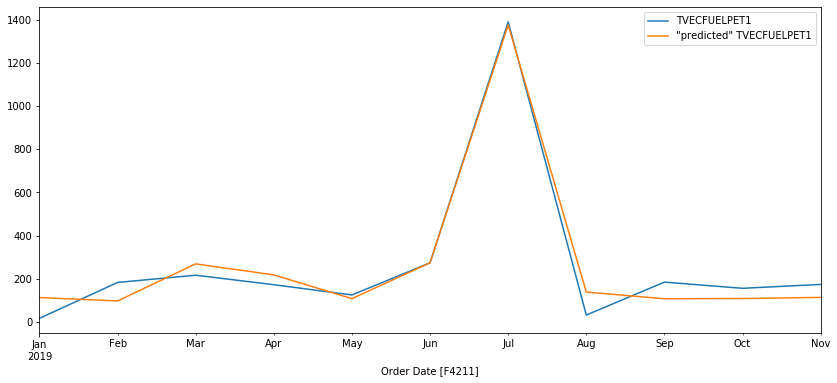

In [44]:
itemsCorrModP_mod2[["TVECFUELPET1",'"predicted" TVECFUELPET1']].plot()

As we can see, model fits quite good. It enables us to predict petrol quantity upon wood orders volume.

- Another approach of model validation: Test/Train sets

In [30]:
test = pd.DataFrame()
train = pd.DataFrame()

modelT = itemsCorrModP.iloc[:,:4]

for i in range (0,11):
    if i%2==0:
        train = train.append(modelT.iloc[i:i+1,:])
    else:
        test = test.append(modelT.iloc[i:i+1,:])
        


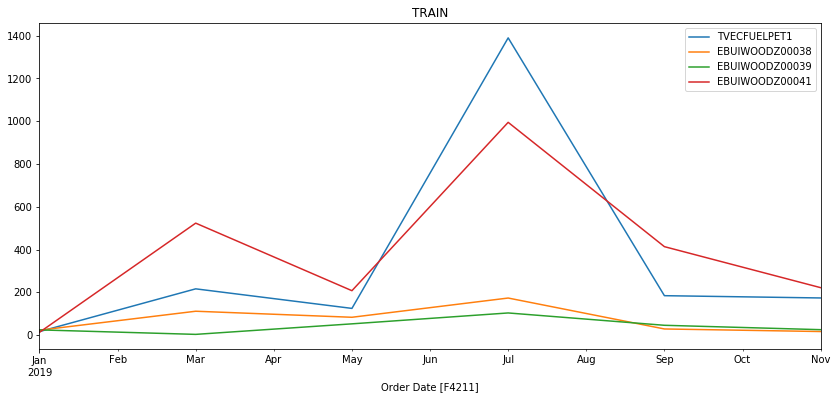

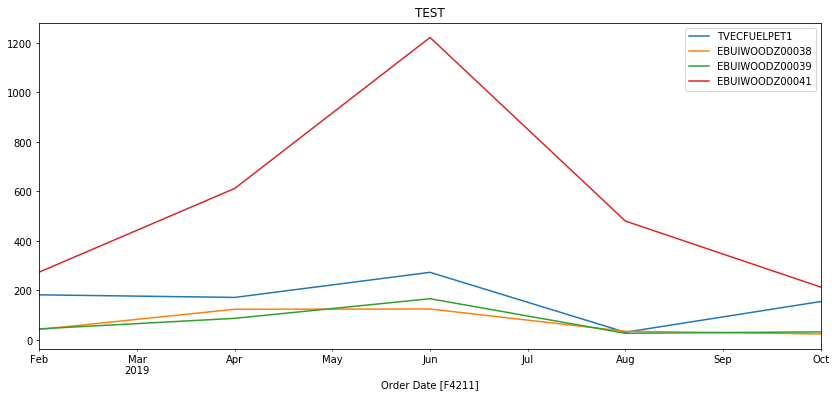

In [65]:
train.plot(title = "TRAIN")
test.plot(title = "TEST")


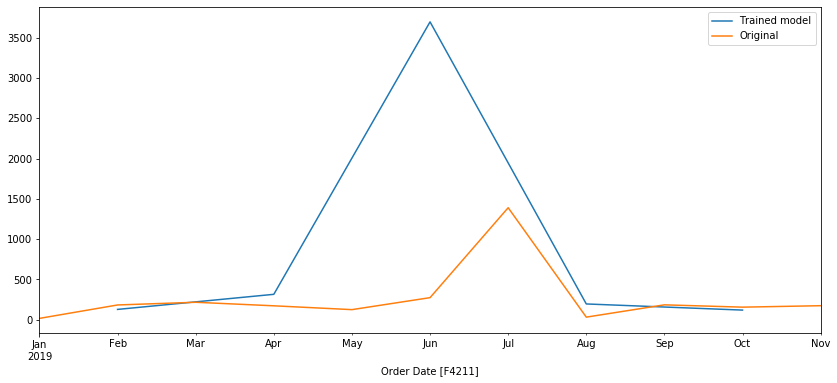

In [66]:
train_reg = smf.ols("TVECFUELPET1 ~ np.power(EBUIWOODZ00039,3) + np.power(EBUIWOODZ00038,5) + np.power(EBUIWOODZ00041,4)",
                      data=train).fit()
test_res = train_reg.predict(test)

test_res.plot(label = "Trained model")
itemsCorrModP["TVECFUELPET1"].plot(label = "Original")
plt.legend()

In [33]:
train_reg.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:           TVECFUELPET1   R-squared:                       0.990
Model:                            OLS   Adj. R-squared:                  0.974
Method:                 Least Squares   F-statistic:                     64.35
Date:                Thu, 26 Mar 2020   Prob (F-statistic):             0.0153
Time:                        21:14:27   Log-Likelihood:                -31.679
No. Observations:                   6   AIC:                             71.36
Df Residuals:                       2   BIC:                             70.53
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
===============================================================================================
                                  coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------------
Intercept                     113.6299     42.748      2.658      0.117     -70.299     297.559
np.power(EBUIWOODZ00039, 3)  5.879e-05      0.001      0.112      0.921      -0.002       0.002
np.power(EBUIWOODZ00038, 5) -1.697e-09   1.11e-08     -0.153      0.893   -4.95e-08    4.62e-08
np.power(EBUIWOODZ00041, 4)  1.508e-09   1.98e-09      0.762      0.526   -7.01e-09       1e-08
==============================================================================
Omnibus:                          nan   Durbin-Watson:                   1.146
Prob(Omnibus):                    nan   Jarque-Bera (JB):                1.471
Skew:                          -1.198   Prob(JB):                        0.479
Kurtosis:                       3.384   Cond. No.                     5.17e+11
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 5.17e+11. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

Considering high r2 and visualisation, I can definitely atell model above is valid to be ised for forecasting.

#### I tried to forecast wood quantity, even though backwards autocorralation analysis showed low values.  Again, I am using linear regression. In this case as feature I am taking lagged variables.

Preparing data:


In [34]:
itemCode = "EBUIWOODZ00038" #Choosing item code

In [35]:
itemsCorrModP_mod3 = mySRs[mySRs["2nd Item Number [F4211]"] == itemCode][["Order Date [F4211]","Quantity Ordered [F4211]"]]
itemsCorrModP_mod3.set_index ("Order Date [F4211]", inplace = True)
itemsCorrModP_mod3.index.names = ["Date"]
itemsCorrModP_mod3.rename(columns = {"Quantity Ordered [F4211]" : itemCode}, inplace = True)

itemsCorrModP_mod3.index = pd.to_datetime(itemsCorrModP_mod3.index)
itemsCorrModP_mod3 = itemsCorrModP_mod3[itemCode].resample('M').mean()
itemsCorrModP_mod3 = itemsCorrModP_mod3.dropna()
itemsCorrModP_mod3 = pd.DataFrame(itemsCorrModP_mod3)

itemsCorrModP_mod3


,EBUIWOODZ00038
Date,
2019-01-31,22.500000
2019-02-28,42.666667
2019-03-31,111.250000
2019-04-30,124.250000
2019-05-31,83.000000
2019-06-30,125.200000
2019-07-31,173.000000
2019-08-31,35.250000
2019-09-30,28.307692


Creting new DF with original and 4 lagged variables columns:

In [36]:
itemsCorrModP_mod3S1 = itemsCorrModP_mod3.shift(1)

itemsCorrModP_mod3S1.rename (columns={itemCode:itemCode+"_1"}, inplace = True)

itemsCorrModP_mod3S2 = itemsCorrModP_mod3.shift(2)
itemsCorrModP_mod3S2.rename (columns={itemCode:itemCode+"_2"}, inplace = True)

itemsCorrModP_mod3S3 = itemsCorrModP_mod3.shift(3)
itemsCorrModP_mod3S3.rename (columns={itemCode:itemCode+"_3"}, inplace = True)

itemsCorrModP_mod3S4 = itemsCorrModP_mod3.shift(4)
itemsCorrModP_mod3S4.rename (columns={itemCode:itemCode+"_4"}, inplace = True)

ResMod = pd.merge (itemsCorrModP_mod3, itemsCorrModP_mod3S1, how = "inner", on = "Date")
ResMod = pd.merge (ResMod, itemsCorrModP_mod3S2, how = "inner", on = "Date")
ResMod = pd.merge (ResMod, itemsCorrModP_mod3S3, how = "inner", on = "Date")
ResMod = pd.merge (ResMod, itemsCorrModP_mod3S4, how = "inner", on = "Date")
ResMod


,EBUIWOODZ00038,EBUIWOODZ00038_1,EBUIWOODZ00038_2,EBUIWOODZ00038_3,EBUIWOODZ00038_4
Date,,,,,
2019-01-31,22.500000,NaN,NaN,NaN,NaN
2019-02-28,42.666667,22.500000,NaN,NaN,NaN
2019-03-31,111.250000,42.666667,22.500000,NaN,NaN
2019-04-30,124.250000,111.250000,42.666667,22.500000,NaN
2019-05-31,83.000000,124.250000,111.250000,42.666667,22.500000
2019-06-30,125.200000,83.000000,124.250000,111.250000,42.666667
2019-07-31,173.000000,125.200000,83.000000,124.250000,111.250000
2019-08-31,35.250000,173.000000,125.200000,83.000000,124.250000
2019-09-30,28.307692,35.250000,173.000000,125.200000,83.000000


Using General instead of ordinay, i use generalized LS in order to minimize std error. In the same time I am using covrarinace matrix HAC.

In [37]:
wood_reg = smf.gls("EBUIWOODZ00038 ~ EBUIWOODZ00038_1 + EBUIWOODZ00038_2 + EBUIWOODZ00038_3+ EBUIWOODZ00038_4", 
                   data=ResMod).fit(cov_type = "HAC",cov_kwds={'maxlags':7})
wood_reg.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            GLS Regression Results                            
==============================================================================
Dep. Variable:         EBUIWOODZ00038   R-squared:                       0.426
Model:                            GLS   Adj. R-squared:                 -0.722
Method:                 Least Squares   F-statistic:                     21.34
Date:                Thu, 26 Mar 2020   Prob (F-statistic):             0.0453
Time:                        21:14:27   Log-Likelihood:                -36.132
No. Observations:                   7   AIC:                             82.26
Df Residuals:                       2   BIC:                             81.99
Df Model:                           4                                         
Covariance Type:                  HAC                                         
====================================================================================
                       coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------
Intercept           94.8649     31.352      3.026      0.002      33.415     156.314
EBUIWOODZ00038_1     0.5006      0.114      4.384      0.000       0.277       0.724
EBUIWOODZ00038_2    -0.4173      0.160     -2.601      0.009      -0.732      -0.103
EBUIWOODZ00038_3     0.3189      0.300      1.064      0.287      -0.269       0.906
EBUIWOODZ00038_4    -0.6061      0.137     -4.419      0.000      -0.875      -0.337
==============================================================================
Omnibus:                          nan   Durbin-Watson:                   2.326
Prob(Omnibus):                    nan   Jarque-Bera (JB):                0.511
Skew:                           0.519   Prob(JB):                        0.774
Kurtosis:                       2.178   Cond. No.                     1.06e+03
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 7 lags and without small sample correction
[2] The condition number is large, 1.06e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

##### Comments: 
Rr2 is lower than 0,5, which means model is not reliable enough. In the same time, std error is still quite high.

Here is backward visualisation:

In [38]:
resModF = ResMod
resModF [' "predicted" EBUIWOODZ00038 '] = wood_reg.predict(ResMod)
resModF

,EBUIWOODZ00038,EBUIWOODZ00038_1,EBUIWOODZ00038_2,EBUIWOODZ00038_3,EBUIWOODZ00038_4,"""predicted"" EBUIWOODZ00038"
Date,,,,,,
2019-01-31,22.500000,NaN,NaN,NaN,NaN,NaN
2019-02-28,42.666667,22.500000,NaN,NaN,NaN,NaN
2019-03-31,111.250000,42.666667,22.500000,NaN,NaN,NaN
2019-04-30,124.250000,111.250000,42.666667,22.500000,NaN,NaN
2019-05-31,83.000000,124.250000,111.250000,42.666667,22.500000,110.601011
2019-06-30,125.200000,83.000000,124.250000,111.250000,42.666667,94.175203
2019-07-31,173.000000,125.200000,83.000000,124.250000,111.250000,95.086819
2019-08-31,35.250000,173.000000,125.200000,83.000000,124.250000,80.368550
2019-09-30,28.307692,35.250000,173.000000,125.200000,83.000000,29.930847


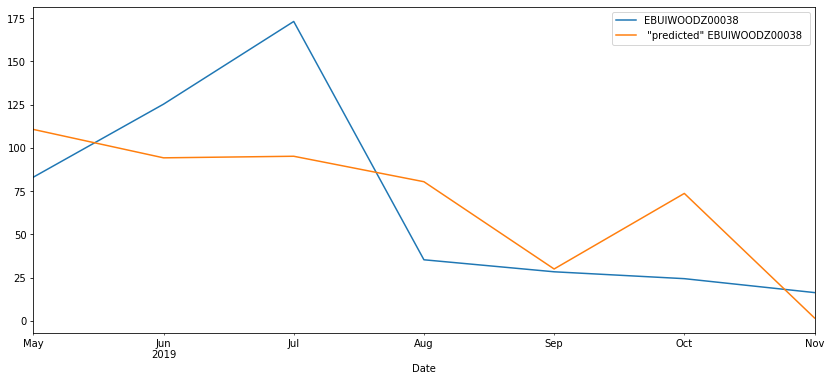

In [67]:
resModF[["EBUIWOODZ00038",' "predicted" EBUIWOODZ00038 ']].dropna().plot()

There are several reasond why dataset might be not good for forecasts. I checked the following:


- Shapiro test:

In [40]:
from scipy import stats
stats.shapiro(itemsCorrModP_mod3)

(0.8674787282943726, 0.07194061577320099)

- Outliers reserach:

In [41]:
np.where(abs(stats.zscore(itemsCorrModP_mod3)>3))

(array([], dtype=int64), array([], dtype=int64))

##### Conclusion:
Data is more likly to be normally distributed: 0.07 > 0.05 (standard significant level). In addition, there are no outliers in wood dataset. Unfortunately, at the first glance, there is no reason why dataset doesn't have evough level of correlation in order to be forecasted.

#### Even though GSL model doesn't fit well, I still decided to use its statistics for EBUIWOODZ00038 next month volumes preditions:

In [42]:
y1 = 94.8649 + 16.285714*0.5006 + 24.333333*0.4173 + 28.307692*0.3189 + 35.250000*(-0.6061) #month1
y1 = round(y1)
print ("Predicted EBUIWOODZ00038 :", y1, "pcs.")

Predicted EBUIWOODZ00038 : 101 pcs.


In [43]:
stats.ttest_1samp(itemsCorrModP["EBUIWOODZ00038"],y1)

Ttest_1sampResult(statistic=-1.8080307941265072, pvalue=0.10072525235796585)

Forecasted value of fuel wood suits the dataset: p = 0.1> 0.05 (standard significant level)

#### Going back to correlation inside dataset:

In [44]:
itemsCorrModP.corr()

,TVECFUELPET1,EBUIWOODZ00038,EBUIWOODZ00039,EBUIWOODZ00041,"""predicted"" TVECFUELPET1"
TVECFUELPET1,1.000000,0.693486,0.427392,0.581358,0.984285
EBUIWOODZ00038,0.693486,1.000000,0.648259,0.795878,0.732416
EBUIWOODZ00039,0.427392,0.648259,1.000000,0.834656,0.415042
EBUIWOODZ00041,0.581358,0.795878,0.834656,1.000000,0.599350
"""predicted"" TVECFUELPET1",0.984285,0.732416,0.415042,0.599350,1.000000


As we can see, there is a high correlation between EBUIWOODZ00038 and EBUIWOODZ00041. I decided to check it and use to estimate EBUIWOODZ00041 value upon EBUIWOODZ00038:

Linear model and it's cross-validation:

In [118]:
modelT2 = itemsCorrModP.iloc[:,:4]
kf = model_selection.KFold(n_splits=2,shuffle=True)
tr2, tst2 = kf.split(modelT2)
train2 = modelT2.iloc[tr2[1]]
test2 = modelT2.iloc[tst2[1]]

In [119]:
slope, intercept, r_value, p_value, slope_std_error = stats.linregress(train2['EBUIWOODZ00038'], train2["EBUIWOODZ00041"])

In [120]:
train_regr = intercept + slope * train2["EBUIWOODZ00038"]

print ("R2, training model: ",metrics.r2_score(train2["EBUIWOODZ00041"],train_regr))

R2, training model:  0.7157628903033201


In [121]:
print ("R2, testing model: ",metrics.r2_score(test2['EBUIWOODZ00041'], intercept + slope*test2["EBUIWOODZ00038"]))

R2, testing model:  0.5136590460738004


In [122]:
print('R-squared value is', metrics.r2_score(train2["EBUIWOODZ00041"], intercept + slope*train2["EBUIWOODZ00038"]))
print('MAE is', metrics.mean_absolute_error(train2["EBUIWOODZ00041"], intercept + slope*train2["EBUIWOODZ00038"]))
print('Mean and std are', itemsCorrModP['EBUIWOODZ00041'].mean(), itemsCorrModP['EBUIWOODZ00041'].std())

R-squared value is 0.7157628903033201
MAE is 117.73582781608093
Mean and std are 470.5746950019677 362.14415601810015


Even though r2 is high, MAE is fairly low. Model doesn't seem to be reliable, but I am still plannin to use it:


In [123]:
y2 = intercept + slope *y1
print ("Predicted EBUIWOODZ00041 :", y2, "pcs.")

Predicted EBUIWOODZ00041 : 546.3897213569521 pcs.


#### To test the first model, let's make the follwoing supply order:

In [124]:
pcw = pd.DataFrame({'TVECFUELPET1':[np.NaN], 'EBUIWOODZ00038':[y1], 'EBUIWOODZ00039':[20], 
                    'EBUIWOODZ00041':[y2]},
                   index=pd.date_range('2019-12-31',periods=1,freq='M'))

p.s. Influence of EBUIWOODZ00039 is next to 0, so I took prior month value.

Here is predicted value:

In [125]:
new_model = itemsCorrModP.append(pcw).iloc[11:,:].round()
new_model_pred = new_model
new_model_pred ["'predicted' TVECFUELPET1"] = y3 = petrol_reg.predict(new_model),
new_model_pred = new_model_pred.round()
print ("Predicted TVECFUELPET1 (date  liters):",y3[0])
new_model_pred.iloc[:,1:].round()

Predicted TVECFUELPET1 (date  liters): 2019-12-31    229.334027
dtype: float64


,EBUIWOODZ00038,EBUIWOODZ00039,EBUIWOODZ00041,'predicted' TVECFUELPET1
2019-12-31,101.0,20.0,546.0,"(229.33402747445479,)"


Here is t-Test to check whether y1 fits the set:

In [126]:
stats.ttest_1samp(itemsCorrModP["TVECFUELPET1"],185)

Ttest_1sampResult(statistic=0.700243742583019, pvalue=0.4997417800997367)

### Forecasted value of fuel suits given dataset: p = 0.49> 0.05 (standard significant level)

# -------------FINISH-------------------------

# --------------------------------------

# Rough drafts: kind of notes, tries and fails

### ARIMA - another option that failed

Before starting forecasting, we have to make sure, that time series is stationary.

##### Check Stationarity of a Time Series.

We can assume the series to be stationary if it has constant statistical properties over time, ie. the following:

1. constant mean
2. constant variance
3. an autocovariance that does not depend on time.

Plotting Rolling Statistics:

In [54]:
from statsmodels.tsa.stattools import adfuller

def test_stationarity(timeseries):
    
    #Determing rolling statistics
    rolmean = timeseries.rolling(10).mean()
    rolstd = timeseries.rolling(10).std()
    
    #plottig
    orig = plt.plot(timeseries, color='#cc5c78',label='Original', linestyle=':')
    mean = plt.plot(rolmean, color='#4e75b5', label='Rolling Mean', linewidth = 4)
    std = plt.plot(rolstd, color='#89c989', label = 'Rolling Std', linewidth = 4)
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block=False)
    
    print ('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries.iloc[:,0].values, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    
    print (dfoutput)

In [55]:
test_stationarity (wood)

NameError: name 'wood' is not defined

##### Comment: 
Both std and mean are clearly changing over the time -> wood is not a stationary series.

There are 2 major reasons behind non-stationaruty of a TS:
1. Trend
2. Seasonality

One of the first tricks to reduce trend is transformation. I took a log transform:

In [ ]:
wood_log = np.log(wood).dropna()
wood_log.plot(color='#cc5c78', linestyle=':')
plt.legend(loc='best')

Next step towards stationarity is smooting.

In first approach, I take rolling average of 10 consecutive values:

In [ ]:
moving_avg = wood_log.rolling(10).mean()
#plt.plot(wood_log, color='#cc5c78', label ='Log (Original)', linestyle=':')
#plt.plot(moving_avg, color='#4e75b5', label = 'Rolling Mean',linewidth = 4)
#plt.legend(loc='best')
wood_log_moving_avg_diff = wood_log - moving_avg
wood_log_moving_avg_diff.dropna(inplace=True)
test_stationarity(wood_log_moving_avg_diff)

This looks like a much better series. The test statistic is smaller than the 5% critical values so we can say with 95% confidence that this is a stationary series.

In second approach, I exponentially weighted moving average:

In [ ]:
expwighted_avg = wood_log.ewm(halflife=10).mean()
#plt.plot(wood_log, color='#cc5c78', label ='Log (Original)', linestyle=':')
#plt.plot(expwighted_avg, color='#4e75b5', label = 'Exponentially weighted moving average',linewidth = 4)
wood_log_ewma_diff = wood_log - expwighted_avg
test_stationarity(wood_log_ewma_diff)

This TS has even lesser variations in mean and standard deviation in magnitude. Also, the test statistic is smaller than the 1% critical value, which is better than the first approach.

Another step is differencing:

In [ ]:
wood_log_diff = wood_log - wood_log.shift()
wood_log_diff.dropna(inplace=True)
test_stationarity(wood_log_diff)

Forecasting itself:

In [ ]:
from statsmodels.tsa.stattools import acf, pacf
lag_acf = acf(wood_log_diff, nlags=20)
lag_pacf = pacf(wood_log_diff, nlags=20, method='ols')

In [ ]:
#Plot ACF: 
plt.subplot(121) 
plt.plot(lag_acf)
plt.axhline(y=0,linestyle='--',color='gray')
plt.axhline(y=-1.96/np.sqrt(len(wood_log_diff)),linestyle='--',color='gray')
plt.axhline(y=1.96/np.sqrt(len(wood_log_diff)),linestyle='--',color='gray')
plt.title('Autocorrelation Function')

#Plot PACF:
plt.subplot(122)
plt.plot(lag_pacf)
plt.axhline(y=0,linestyle='--',color='gray')
plt.axhline(y=-1.96/np.sqrt(len(wood_log_diff)),linestyle='--',color='gray')
plt.axhline(y=1.96/np.sqrt(len(wood_log_diff)),linestyle='--',color='gray')
plt.title('Partial Autocorrelation Function')
plt.tight_layout()

In these plots we can find confidence interevals. I used it to determine the ‘p’ and ‘q’ values:

p – The lag value where the PACF chart crosses the upper confidence interval for the first time. If you notice closely, in this case p=2.

q – The lag value where the ACF chart crosses the upper confidence interval for the first time. If you notice closely, in this case q=2.

In [ ]:
from statsmodels.tsa.arima_model import ARIMA

AR Model

In [ ]:
model = ARIMA(wood_log, order=(15, 1, 0))  
results_AR = model.fit(disp=-1)  
plt.plot(wood_log_diff)
plt.plot(results_AR.fittedvalues, color='red')
#plt.title('RSS: %.4f'% sum((results_AR.fittedvalues-wood_log_diff)**2))


MA Model

In [ ]:
model = ARIMA(wood_log, order=(0, 1, 2))  
results_MA = model.fit(disp=-1)  
plt.plot(wood_log_diff)
plt.plot(results_MA.fittedvalues, color='red')
#plt.title('RSS: %.4f'% sum((results_MA.fittedvalues-wood_log_diff)**2))

Combined Model

In [ ]:
model = ARIMA(wood_log, order=(2, 1, 2))  
results_ARIMA = model.fit(disp=-1)  
plt.plot(wood_log_diff)
plt.plot(results_ARIMA.fittedvalues, color='red')
#plt.title('RSS: %.4f'% sum((results_ARIMA.fittedvalues-ts_log_diff)**2))

In [ ]:
#predictions_ARIMA_log = pd.Series(wood_log.ix[0], index=wood_log.index)
#predictions_ARIMA_log = predictions_ARIMA_log.add(predictions_ARIMA_diff_cumsum,fill_value=0)
#predictions_ARIMA_log.head()

In [ ]:
predictions_ARIMA = np.exp(predictions_ARIMA_log)
plt.plot(wood)
plt.plot(predictions_ARIMA)

In [ ]:
wood = mySRs[mySRs["2nd Item Number [F4211]"] == "EBUIWOODZ00041"][["Order Date [F4211]","Quantity Ordered [F4211]"]]
wood.set_index("Order Date [F4211]", inplace = True)
wood.index = pd.to_datetime(wood.index)
wood.groupby ("Order Date [F4211]").agg(sum)
wood.rename(columns = {"Quantity Ordered [F4211]":"EBUIWOODZ00041"}, inplace = True)
#wood = wood["EBUIWOODZ00041"].resample('W').mean()
wood = pd.DataFrame (wood).dropna()
wood.head()

In [ ]:

#import numpy
#import matplotlib.pyplot as plt
#import pandas
#import math
#from keras.models import Sequential
#from keras.layers import Dense
#from keras.layers import LSTM
#from sklearn.preprocessing import MinMaxScaler
#from sklearn.metrics import mean_squared_error

In [ ]:
#from fbprophet import Prophet
#wood_model = Prophet(interval_width=0.95)
#wood_model.fit(wood)

#wood_forecast = wood_model.make_future_dataframe(periods=3, freq='M')
#wood_forecast = wood_model.predict(wood_forecast)

#plt.figure(figsize=(18, 6))
#wood_model.plot(wood_forecast, xlabel = 'Date', ylabel = 'Orders')
#plt.title('EBUIWOODZ0004 forecast');

In [ ]:
parcelsMod = pd.DataFrame()
hyg = mySRsPlot[mySRsPlot["2nd Item Number [F4211]"]=="KRELHYPA01P1"]
x = hyg["Quantity Ordered [F4211]"].resample('M').mean()
food = mySRsPlot[mySRsPlot["2nd Item Number [F4211]"]=="KRELFOPA01P"]
y = food["Quantity Ordered [F4211]"].resample('M').mean()

parcelsMod = pd.merge (x,y, how = "inner", on = "Order_date")
parcelsMod.rename(columns = {"Quantity Ordered [F4211]_x":"KRELHYPA01P1"}, inplace = True)
parcelsMod.rename(columns = {"Quantity Ordered [F4211]_y":"KRELFOPA01P"},inplace = True)
parcelsMod

In [ ]:
parcelsMod.loc[:, ['KRELHYPA01P1', 'KRELFOPA01P']].cov()

In [ ]:
parcelsMod.loc[:, ['KRELHYPA01P1', 'KRELFOPA01P']].corr()

In [ ]:
parcelsMod.plot()

#### Option #1


In [ ]:
decomposition = seasonal_decompose(wood, model='multiplicative', freq=1)
fig = decomposition.plot()
plt.show()

In [ ]:
data = np.log(wood).diff().dropna()
data
model = VAR (data)

As there is no correlation whithin 1 year, we can try to check whether there is seasonality. For this I've added data from year 2017 and 2018

In [ ]:
#adding 2017,2018

myOrders18 = pd.read_csv('mySR2018.csv')
myOrders17 = pd.read_csv('mySR2017.csv')

myOrders18 = myOrders18.rename(columns = {'Business Unit [F4211]':'Business unit','Or Ty [F4211]':'Order type'})
myOrders17 = myOrders17.rename(columns = {'Business Unit [F4211]':'Business unit','Or Ty [F4211]':'Order type'})

delCol (myOrders18, cols)
delCol (myOrders17, cols)

mySRs18 = myOrders18[myOrders18["Order type"]=="SR"]
mySRs17 = myOrders17[myOrders17["Order type"]=="SR"]


mySRsT = pd.DataFrame()
mySRsT = mySRsT.append(mySRs, sort=True).append(mySRs18, sort=True).append(mySRs17, sort=True)
hygMod = mySRsT[mySRsT["2nd Item Number [F4211]"] == "KRELHYPA01P1"]
hygMod

In [ ]:
hygModRes = hygMod[["Order Date [F4211]","2nd Item Number [F4211]", "Quantity Ordered [F4211]"]]
hygModRes = hygModRes[hygModRes["Quantity Ordered [F4211]"]!=0]
hygModRes = hygModRes.groupby("Order Date [F4211]")["Quantity Ordered [F4211]"].sum().reset_index()
hygModRes = hygModRes.set_index("Order Date [F4211]")
hygModRes.index = pd.to_datetime(hygModRes.index)
hygModRes.rename(columns = {'Quantity Ordered [F4211]':'KRELHYPA01P1'}, inplace = True)
a = hygModRes["KRELHYPA01P1"].resample('M').mean()
a

In [ ]:
a.plot()

In [ ]:
decomposition = seasonal_decompose(parcelsMod, model='multiplicative', freq=1)
fig = decomposition.plot()
plt.show()

In [ ]:
#Enal.describe()

In [ ]:
#import statsmodels.formula.api as smf
#mod = Enal
#mod ["Order_date1"] = 0
#mod.iloc[:,0:0]

In [ ]:


#mod_reg = smf.ols("Quantity_ordered ~ Order_date", data=mod).fit() 
#mod_reg.summary()

In [ ]:
#y = Enal["Quantity_ordered"].resample('M').mean()
#corrMod["Quantity_ordered"].resample('M').mean()

In [ ]:
#y.plot()
#plt.show()

In [ ]:
#petrol_reg = smf.ols("TVECFUELPET1 ~ EBUIWOODZ00038 + EBUIWOODZ00039 + EBUIWOODZ00041", data=itemsCorrModP).fit()  # this is a shortcut to the above
#petrol_reg.summary()


In [ ]:
#itemsCorrModP.describe()

In [ ]:
#itemsCorrModP_mod = itemsCorrModP
#itemsCorrModP_mod['predicted TVECFUELPET1'] = petrol_reg.predict(itemsCorrModP)


In [ ]:
#itemsCorrModP_mod[["TVECFUELPET1","predicted TVECFUELPET1"]].plot()

In [ ]:

#cols = ["Order Co [F4211]","Ord Suf [F4211]","Co  [F4211]","Doc Co [F4211]","Co Key [F4211]",
#"Related PO/SO No [F4211]","Related PO/SO Line No [F4211]","Agreement Number [F4211]",
#"Address Number [F4211]","Ship To Number [F4211]", "Original Line Number [F4211]",
#"Sched Pick [F4211]","Actual Ship Date [F4211]","Invoice Date [F4211]","Cancel Date [F4211]","G/L Date [F4211]",
#"Promised Delivery [F4211]", "Price Effective Date [F4211]", "Short Item No [F4211]", "3rd Item Number [F4211]", 
#"Frm Grd [F4211]", "Thr Grd [F4211]","Description Line 2 [F4211]",
 #   "Ln Ty [F4211]",
#"Secondary Qty Ordered [F4211]", "Sec UM [F4211]", "Order Status 16 [F4211]", "Deliver To Number [F4211]",
#"Revision Reason [F4211]","Pending Approval [F4211]","Chg Ord [F4211]","Mod Trn [F4211]","Pull Signal [F4211]",
#"Scheduled Pick Time [F4211]", "Original The [F4211]","Actual Ship Time [F4211]", 
 #   "Promised Ship [F4211]",
#"Ship To Line ID [F4211]","Sub Type [F4211]", "Cross Dock Order Co [F4211]",
#"Cross Dock Order Number [F4211]", "Cross Dock Order Type [F4211]", "Cross Dock Line Number [F4211]",
#"Cross Dock Order Suffix [F4211]", "Primary Supplier [F4211]","Max Lead time [F4211]","Import Licence [F4211]",
#"Item Option [F4211]","Purch Cat Code 3 [F4211]", "Plan Fmly [F4211]", "Co Key [F4211]"]


#delCol (myOrders, cols)

In [ ]:
#p = d = q = range(0, 2)
#pdq = list(itertools.product(p, d, q))
#seasonal_pdq = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))]
#print('Examples of parameter combinations for Seasonal ARIMA...')
#print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[1]))
#print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[2]))
#print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[3]))
#print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[4]))

In [ ]:
#series = [i for i in range(1,100)]
#result = seasonal_decompose(series, model='additive', freq=1)
#result.plot()
#plt.show()

In [ ]:
#TopFive = Desc.groupby("2nd Item Number [F4211]")["Unit Cost [F4211]"].agg(sum)
#TopFive = pd.DataFrame(TopFive)
#TopFive = TopFive.sort_values("Unit Cost [F4211]", ascending = False)

#TopFive.head(50)

In [ ]:
#fig = plt.figure() # Create matplotlib figure

#ax = fig.add_subplot(111) # Create matplotlib axes
#ax2 = ax.twinx() # Create another axes that shares the same x-axis as ax.

#width = 0.45

#OrAn_DF["Orders cost (CHF)"].plot(kind='bar', color='#ff9999', ax=ax, width=width, position=1)
#OrAn_DF["Orders quantity"].plot(kind='bar', color='#66b3ff', ax=ax2, width=width, position=0)

#ax.set_ylabel('Orders cost (CHF)')
#ax2.set_ylabel('Orders quantity')

In [ ]:
# create figure and axis objects with subplots()
#fig,ax = plt.subplots()

# make a plot
#ax.plot(OrAn_DF["Orders cost (CHF)"],  color="red", marker="o")
# set x-axis label
#ax.set_xlabel("Type of delivry",fontsize=14)
# set y-axis label
#ax.set_ylabel("Orders cost (CHF)",color="red",fontsize=14)

# twin object for two different y-axis on the sample plot
#ax2=ax.twinx()
# make a plot with different y-axis using second axis object
#ax2.plot(OrAn_DF["Orders quantity"], color="blue", marker="o")
#ax2.set_ylabel("Orders quantity",color="blue",fontsize=14)

#plt.show()

In [ ]:
# save the plot as a file
#fig.savefig('two_different_y_axis_for_single_python_plot_with_twinx.jpg',
 #           format='jpeg',
  #          dpi=100,
   #         bbox_inches='tight')


In [ ]:
#submitted SRs by sub-site (table):

#SXtab = mySXs[["Order Number [F4211]","Business unit","Unit Cost [F4211]","Order type"]]
#SXtab.round({"Unit Cost [F4211]":1})

#SXtabG1 = SXtab.groupby("Order type")["Order Number [F4211]"].agg(len)
#SXtabG2 = SXtab.groupby("Order type")["Unit Cost [F4211]"].agg('sum')

#SXtabG = pd.merge (SXtabG1, SXtabG2, how = 'inner', on = 'Order type')

#SXtabG = pd.DataFrame(SXtabG)
#SXtabG = SXtabG.rename(columns={'Order Number [F4211]':'Supply requests, pcs', "Unit Cost [F4211]":"Costs, CHF"})

#OrList = ["Direct deliveries","Deliveries from WH"," Cash advance"]
#OrTyq = SXtabG["Supply requests, pcs"].tolist()
#OrTyc = SXtabG["Costs, CHF"].tolist()
#SXtabG["   "] = OrList

#SXtabG.round({"Costs, CHF":1}) #Why it doesn't work?
#SXtabG[["   ", "Supply requests, pcs", "Costs, CHF"]]
